# Прогнозирование стоимости автомобилей с использованием нейронных сетей

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optuna

[I 2024-06-01 06:33:39,813] A new study created in memory with name: no-name-3c9e3fc7-42bb-42f1-982c-e713c3dc74db
[I 2024-06-01 06:33:44,571] Trial 0 finished with value: 0.10627157773290362 and parameters: {'hidden_dim1': 288, 'hidden_dim2': 93, 'dropout_rate': 0.35735358833287323, 'learning_rate': 0.00011637123926854682}. Best is trial 0 with value: 0.10627157773290362.
[I 2024-06-01 06:33:49,473] Trial 1 finished with value: 0.10931986623576709 and parameters: {'hidden_dim1': 202, 'hidden_dim2': 157, 'dropout_rate': 0.22117708811843773, 'learning_rate': 0.0002786049239301255}. Best is trial 0 with value: 0.10627157773290362.
[I 2024-06-01 06:33:54,057] Trial 2 finished with value: 0.10306342371872493 and parameters: {'hidden_dim1': 147, 'hidden_dim2': 141, 'dropout_rate': 0.10077781087927466, 'learning_rate': 0.000123363230096176}. Best is trial 2 with value: 0.10306342371872493.
[I 2024-06-01 06:33:58,687] Trial 3 finished with value: 0.1101756798369544 and parameters: {'hidden_dim

Best trial:
  Value: 0.09894564641373498
  Params: 
    hidden_dim1: 157
    hidden_dim2: 65
    dropout_rate: 0.1223889175525239
    learning_rate: 0.00010149862971152278
Epoch 1/100, Train Loss: 0.9718, Val Loss: 0.8516
Epoch 2/100, Train Loss: 0.8248, Val Loss: 0.7172
Epoch 3/100, Train Loss: 0.6916, Val Loss: 0.5849
Epoch 4/100, Train Loss: 0.5493, Val Loss: 0.4546
Epoch 5/100, Train Loss: 0.4240, Val Loss: 0.3372
Epoch 6/100, Train Loss: 0.3114, Val Loss: 0.2405
Epoch 7/100, Train Loss: 0.2241, Val Loss: 0.1781
Epoch 8/100, Train Loss: 0.1711, Val Loss: 0.1410
Epoch 9/100, Train Loss: 0.1421, Val Loss: 0.1232
Epoch 10/100, Train Loss: 0.1260, Val Loss: 0.1163
Epoch 11/100, Train Loss: 0.1183, Val Loss: 0.1143
Epoch 12/100, Train Loss: 0.1156, Val Loss: 0.1130
Epoch 13/100, Train Loss: 0.1147, Val Loss: 0.1112
Epoch 14/100, Train Loss: 0.1199, Val Loss: 0.1110
Epoch 15/100, Train Loss: 0.1144, Val Loss: 0.1096
Epoch 16/100, Train Loss: 0.1163, Val Loss: 0.1079
Epoch 17/100, Train L

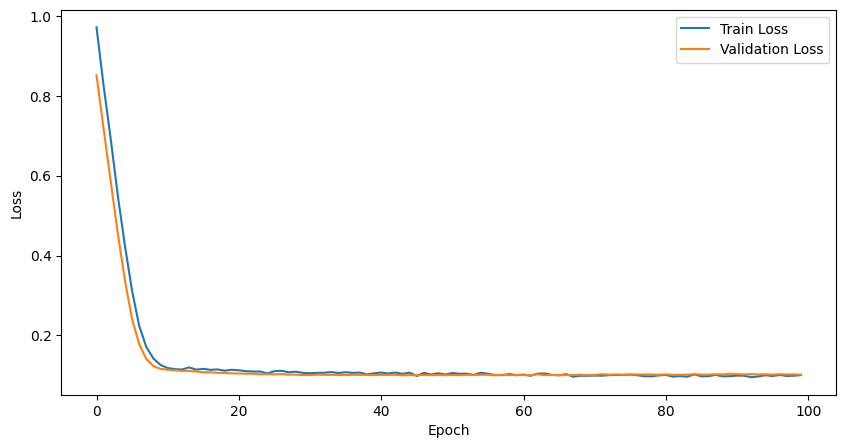

         Actual     Predicted
0  10155.962891  10342.636719
1  11377.835938  11552.948242
2  13996.442383  14194.370117
3   8891.607422   9286.640625
4   6634.610840   6441.522461


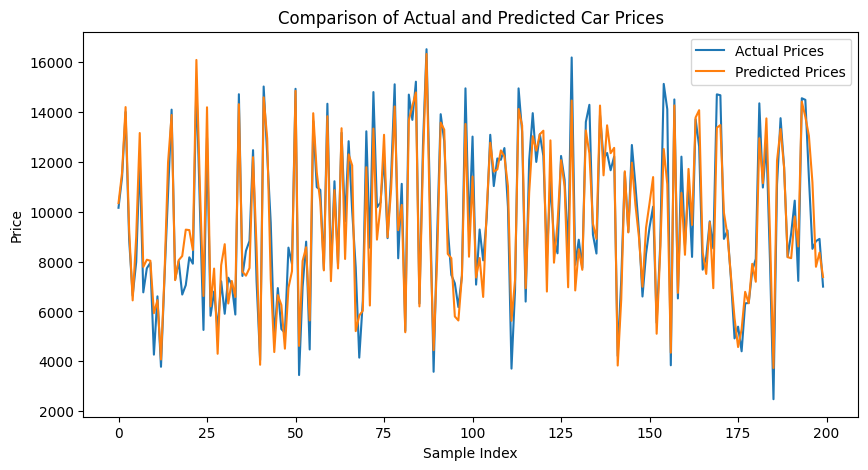

Validation MSE: 964628.3125
Validation R^2: 0.9051


In [7]:
# Генерация синтетических данных
np.random.seed(42)
n_samples = 1000
years = np.random.randint(2000, 2022, n_samples)
mileage = np.random.randint(5000, 200000, n_samples)
fuel_type = np.random.choice(['Petrol', 'Diesel', 'Electric'], n_samples)
engine_size = np.random.uniform(1.0, 4.0, n_samples)
horsepower = np.random.randint(70, 250, n_samples)

# Генерация цен
prices = (years - 2000) * 100 + (200000 - mileage) * 0.05 + (engine_size * 1000) + (horsepower * 10)
prices = prices + np.random.normal(0, 1000, n_samples)  # Добавление шума

data = pd.DataFrame({
    'Year': years,
    'Mileage': mileage,
    'Fuel_Type': fuel_type,
    'Engine_Size': engine_size,
    'Horsepower': horsepower,
    'Price': prices
})

# One-hot encoding категориальной переменной
data = pd.get_dummies(data, columns=['Fuel_Type'], drop_first=True)

# Сохранение скейлера для цен отдельно
price_scaler = StandardScaler()
data[['Price']] = price_scaler.fit_transform(data[['Price']])

# Нормализация числовых признаков
scaler = StandardScaler()
data[data.columns[:-1]] = scaler.fit_transform(data[data.columns[:-1]])

# Разделение данных на признаки и целевую переменную
X = data.drop(columns='Price')
y = data['Price']

# Преобразование в numpy массивы и обеспечение корректных типов
X = X.values.astype(np.float32)
y = y.values.astype(np.float32)

# Определение модели
class CarPriceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_rate):
        super(CarPriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Подготовка данных для PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Устройство для вычислений (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    # Параметры, которые будут оптимизироваться
    hidden_dim1 = trial.suggest_int('hidden_dim1', 128, 512)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3)
    
    model = CarPriceModel(input_dim=X.shape[1], hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout_rate=dropout_rate).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 50
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
    
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Обучение модели с оптимальными гиперпараметрами
best_params = trial.params
model = CarPriceModel(input_dim=X.shape[1], hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], dropout_rate=best_params['dropout_rate']).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

# Обучение модели
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)

# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Предсказание на валидационном наборе данных
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

# Преобразование предсказанных и реальных значений в numpy массивы
predictions = np.array(predictions)
actuals = np.array(actuals)

# Обратное масштабирование цен
actuals = price_scaler.inverse_transform(actuals)
predictions = price_scaler.inverse_transform(predictions)

# Создание DataFrame для сравнения
comparison_df = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()})

# Вывод нескольких строк из DataFrame для визуального сравнения
print(comparison_df.head())

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(actuals.flatten(), label='Actual Prices')
plt.plot(predictions.flatten(), label='Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.title('Comparison of Actual and Predicted Car Prices')
plt.show()

# Метрики для оценки модели
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation R^2: {r2:.4f}")